In [1]:
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

from matplotlib import pyplot as plt
import sklearn.preprocessing as prep
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import time
import os

Using TensorFlow backend.


# Loading Data

In [2]:
os.chdir('Data')
os.listdir()

['prices-split-adjusted.csv',
 'RedditNews.csv',
 '.DS_Store',
 'fundamentals.csv',
 'datafest2018-Updated-April12.csv',
 'prices.csv',
 'Stocks',
 'ETFs',
 'securities.csv',
 'all_stocks_5yr.csv']

In [3]:
data = pd.read_csv('all_stocks_5yr.csv')
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [4]:
data.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


# Preprocessing

Testing only with Apple Stock first

In [5]:
# feature for testing: 
# - closing price of the day
# - volume
# - absolute difference of high - low to measure fluctuation
features = ['close','volume','diff']
    
AAPL = data[data['Name']=='AAPL']
AAPL['diff'] =  abs(AAPL.high - AAPL.low)
AAPL = AAPL[features]
print('Shape:',AAPL.shape)

Shape: (1259, 3)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


A simple plot of features

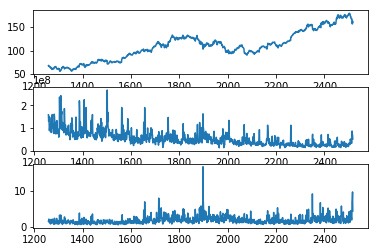

In [6]:
for idx,feature in enumerate(features):
    plt.subplot(len(features),1,idx+1)
    plt.plot(AAPL[feature])
plt.show()

Standardize Input

In [7]:
stan = prep.StandardScaler()
norm = prep.MinMaxScaler()
normy = prep.MinMaxScaler()
normAAPL = norm.fit_transform(AAPL)
stanAAPL = stan.fit_transform(AAPL)
AAPL = np.array(AAPL)

Reframe to supervised learning

Input Dimension: (1253, 5, 3)
Output Dimension:  (1253,)


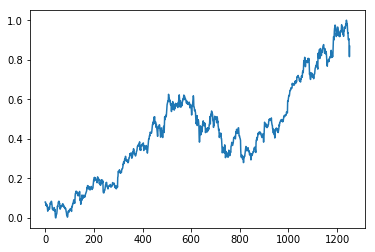

In [37]:
ts = 5
X,y = [],[]
for i in range(AAPL.shape[0]-ts-1):
    X.append(normAAPL[i:i+ts])
    y.append(normAAPL[i+ts,0])
X = np.array(X)
y = np.array(y)
print('Input Dimension:',X.shape)
print('Output Dimension: ',y.shape)
plt.plot(y)
plt.show()

Split Train Test Data

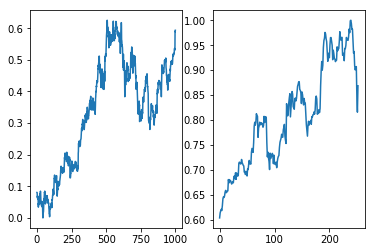

(1000, 5, 3)

In [38]:
X_train,X_test,y_train,y_test = X[:1000],X[1000:],y[:1000],y[1000:]
plt.figure()
plt.subplot(1,2,1)
plt.plot(y_train)
plt.subplot(1,2,2)
plt.plot(y_test)
plt.show()
X_train.shape

# LSTM Model


In [99]:
model = Sequential()

model.add(LSTM(64,input_shape = (5,3),return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(16,return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse',optimizer='adam')
print(time.time()-start)

lstm = model.fit(X_train,y_train,epochs = 30,batch_size=100,validation_split=0.2,shuffle=False)


0.026651859283447266
Train on 800 samples, validate on 200 samples
Epoch 1/30
800/800 [==============================] - 9s 12ms/step - loss: 0.0914 - val_loss: 0.0979
Epoch 2/30
800/800 [==============================] - 0s 219us/step - loss: 0.0403 - val_loss: 0.0343
Epoch 3/30
800/800 [==============================] - 0s 213us/step - loss: 0.0189 - val_loss: 0.0060
Epoch 4/30
800/800 [==============================] - 0s 215us/step - loss: 0.0211 - val_loss: 0.0027
Epoch 5/30
800/800 [==============================] - 0s 215us/step - loss: 0.0193 - val_loss: 0.0043
Epoch 6/30
800/800 [==============================] - 0s 215us/step - loss: 0.0139 - val_loss: 0.0053
Epoch 7/30
800/800 [==============================] - 0s 213us/step - loss: 0.0093 - val_loss: 0.0024
Epoch 8/30
800/800 [==============================] - 0s 216us/step - loss: 0.0062 - val_loss: 7.0835e-04
Epoch 9/30
800/800 [==============================] - 0s 226us/step - loss: 0.0055 - val_loss: 5.8620e-04
Epoch 10

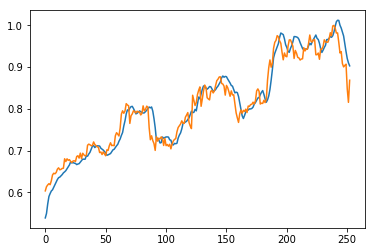

In [105]:
predictions = model.predict(X_test)

plt.plot(predictions)
plt.plot(y_test)
plt.show()

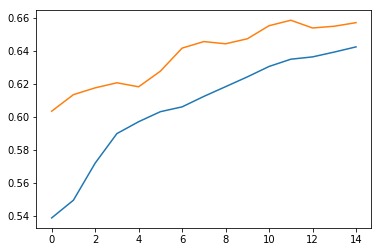

In [110]:
predictions = model.predict(X_test)

plt.plot(predictions[:15])
plt.plot(y_test[:15])
plt.show()

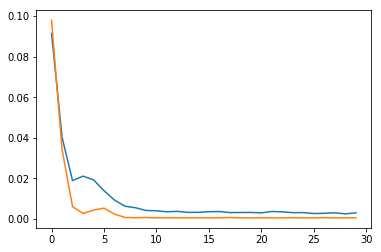

In [108]:
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.show()

Observation: 
    Although it looks like the predicted line fits the actual price curve very well, we need to keep in mind that it could be due to the sliding window methods for predicting future price, the model will fit well by just maintaining the price. Thus we need a better loss function more customized for the situation.     
    Another thought is we could alter the feature input, instead of using close price etc, we could use percentage change per day so that the model could be better at predicting upward trend or downward trend. 
    Lastly, we should test covariance of features and possibly input other stock indicator to train the model. 


NOTE: Need to think of an alternative way to measure error. eg compare the last day with predicted, see if it go up or go down and then find out false postives etc. 